# Variance Reduction Techniques

In this notebook we will explore variance reduction techniques for Monte Carlo simulations. The goal is to reduce the variance of the Monte Carlo simulation without dramatically increasing the computational complexity.

$\textbf{Theory from a lecture at LMU by Dr. Ari-Pekka Perkkiö}$

In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

import fima

In [2]:
T = 1
t = 0
x = 100
r = 0.05
sigma = 0.2

In [3]:
M = 1000000 #number of simulations

### Importance Sampling

The idea of importance sampling is to look for another measure under which the variance of the estimator is smaller. Minimizing variance is equivalent to minimizing the second moment.

Let X be a random variable with density $g(x)$ with respect to the lebesgue measure and let $h(x)$ be another density such that $h > 0$ whenever $g > 0$.

Then

$$
\mathbb{E}_g[X] = \int x g(x) dx = \int x \frac{g(x)}{h(x)} h(x) dx = \mathbb{E}_h[X \frac{g}{h}]
$$

and 

$$
\mathbb{E}_h[(X \frac{g}{h})^2] = \int (x \frac{g(x)}{h(x)})^2 h(x) dx = \mathbb{E}_g[X^2 \frac{g}{h}]
$$

The new Monte Carlo estimator is then

$$
\frac{1}{N} \sum_{i=1}^N X_i \frac{g(X_i)}{h(X_i)}
$$

In our use case:

$X = Payoff(S)$ where S is the stock price at maturity and $S$ is the Geometric Brownian Motion. As before the GBM is simulated using standard normal random variables. So to abbreviate we write $G(Z) = Payoff(GBM(Z))$ where $Z \sim N(0, I)$ and then set $X = G(Z)$.

Let g be the density of $N(0, I)$ and h be the density of $N(\mu, I)$.

Under h, we have $Z \sim N(\mu, I)$ and for a $\tilde{Z} \sim N(0, I)$ we have $\tilde{Z} + \mu \sim N(\mu, I)$. Under g we have $Z \sim N(0, I)$


$$
\mathbb{E}_h[G(Z) \frac{g(Z)}{h(Z)}] = \mathbb{E}_g[G(Z + \mu) \frac{g(Z + \mu)}{h(Z + \mu)}]
$$

So we first find the optimal $\mu$ and we can do MC of $G(Z + \mu) \frac{g(Z + \mu)}{h(Z + \mu)}$ under g.

In [4]:
def mc_importance_sampling(t, x, eta, payoff, is_drift, r, sigma, T):
    if np.isscalar(is_drift):
        is_drift = np.array([is_drift])

    g_h = lambda x_, drift_: np.exp(-np.dot(drift_,x_) + 0.5*np.dot(drift_, drift_))

    assets = fima.GBMpaths(x, r, sigma, T - t, eta + is_drift[:,np.newaxis])

    payoffs = np.exp(-r*(T-t)) * payoff(assets)*g_h(eta + is_drift[:,np.newaxis], is_drift)

    means = np.cumsum(payoffs) / np.arange(1, len(payoffs) + 1)

    #we should do this but this is way to slow in python if implemented like this
    #interval_range = 1.96 * ([np.std(payoffs[:n]) for n in range(1, len(payoffs) + 1)] / np.sqrt(np.arange(1, len(payoffs) + 1)))
    #so we do this instead
    interval_range = 1.96 * np.std(payoffs) / np.sqrt(np.arange(1, len(payoffs) + 1))

    return means, interval_range

In [5]:
def mc_importance_sampling_optimal_drift_intervals(t, x, eta, optimize_eta, payoff, r, sigma, T):
    assets = lambda eta_ :  fima.GBMpaths(x, r, sigma, T - t, eta_)
    
    g_h = lambda x_, drift_: np.exp(-np.dot(drift_,x_) + 0.5*np.dot(drift_, drift_)).flatten()

    optimize_func = lambda drift_ : np.mean(payoff(assets(optimize_eta))**2*g_h(optimize_eta, drift_))

    is_drift = scipy.optimize.minimize(optimize_func, 0, tol=1e-12).x[0]

    payoffs = np.exp(-r*(T-t)) * payoff(assets(eta + is_drift))*g_h(eta + is_drift, is_drift)

    means = np.cumsum(payoffs) / np.arange(1, len(payoffs) + 1)

    #we should do this but this is way to slow in python if implemented like this
    #interval_range = 1.96 * ([np.std(payoffs[:n]) for n in range(1, len(payoffs) + 1)] / np.sqrt(np.arange(1, len(payoffs) + 1)))
    #so we do this instead
    interval_range = 1.96 * np.std(payoffs) / np.sqrt(np.arange(1, len(payoffs) + 1))

    return means, interval_range, is_drift

In [6]:
eta = np.random.normal(size = (1, M))
optimize_eta = np.random.normal(size = (1, int(M/10)))

In [7]:
is_fixed_drift = 0.5

In [8]:
K = 110

true_price = fima.BS_call_price(t, x, K, r, sigma, T)
basic_means, basic_interval_range = fima.basic_mc(t, x, eta, lambda x : fima.european_call_payoff(x, K), r, sigma, T)
is_fixed_means, is_fixed_interval_range = mc_importance_sampling(t, x, eta, lambda x : fima.european_call_payoff(x, K), is_fixed_drift, r, sigma, T)
is_opt_means, is_opt_interval_range, is_opt_drift = mc_importance_sampling_optimal_drift_intervals(t, x, eta, optimize_eta, lambda x : fima.european_call_payoff(x, K), r, sigma, T)

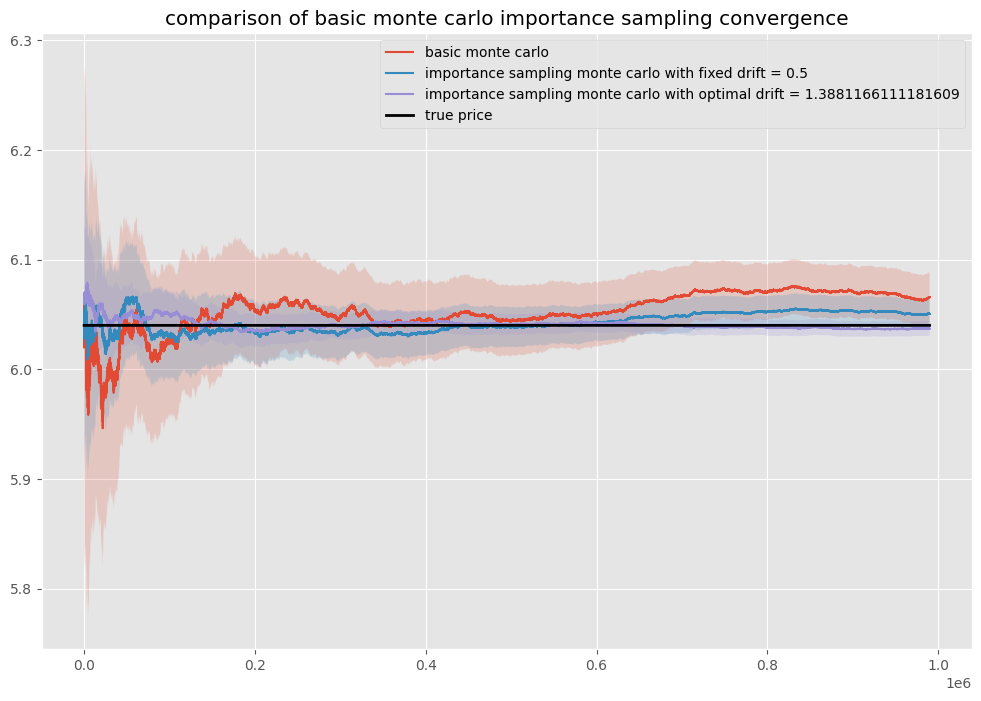

In [9]:
fima.plot_mc(basic_means, basic_interval_range, 'basic monte carlo')
fima.plot_mc(is_fixed_means, is_fixed_interval_range, 'importance sampling monte carlo with fixed drift = ' + str(is_fixed_drift))
fima.plot_mc(is_opt_means, is_opt_interval_range, 'importance sampling monte carlo with optimal drift = ' + str(is_opt_drift))
fima.plot_true_price(true_price, len(basic_means))
plt.title('comparison of basic monte carlo importance sampling convergence')
plt.legend();

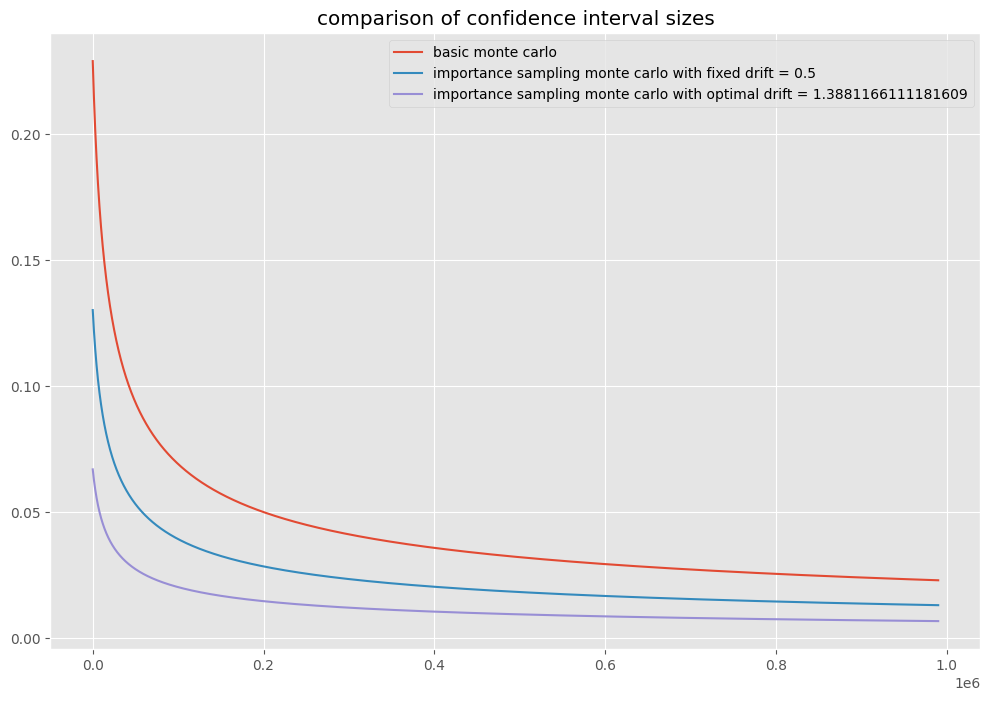

In [10]:
plt.plot(basic_interval_range[int(len(basic_interval_range) * fima.plot_bound):], label = 'basic monte carlo')
plt.plot(is_fixed_interval_range[int(len(is_fixed_interval_range) * fima.plot_bound):], label = 'importance sampling monte carlo with fixed drift = ' + str(is_fixed_drift))
plt.plot(is_opt_interval_range[int(len(is_opt_interval_range) * fima.plot_bound):], label = 'importance sampling monte carlo with optimal drift = ' + str(is_opt_drift))
plt.title('comparison of confidence interval sizes')
plt.legend();

In [11]:
K = 220

true_price = fima.BS_call_price(t, x, K, r, sigma, T)
basic_means, basic_interval_range = fima.basic_mc(t, x, eta, lambda x : fima.european_call_payoff(x, K), r, sigma, T)
is_fixed_means, is_fixed_interval_range = mc_importance_sampling(t, x, eta, lambda x : fima.european_call_payoff(x, K), is_fixed_drift, r, sigma, T)
is_opt_means, is_opt_interval_range, is_opt_drift = mc_importance_sampling_optimal_drift_intervals(t, x, eta, optimize_eta, lambda x : fima.european_call_payoff(x, K), r, sigma, T)

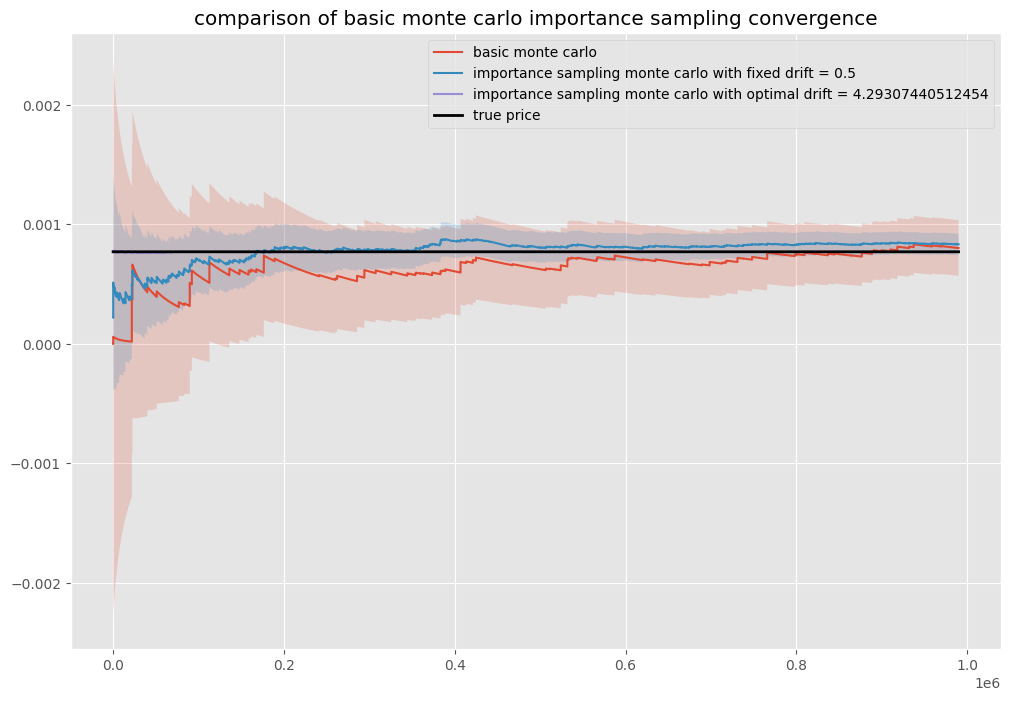

In [12]:
fima.plot_mc(basic_means, basic_interval_range, 'basic monte carlo')
fima.plot_mc(is_fixed_means, is_fixed_interval_range, 'importance sampling monte carlo with fixed drift = ' + str(is_fixed_drift))
fima.plot_mc(is_opt_means, is_opt_interval_range, 'importance sampling monte carlo with optimal drift = ' + str(is_opt_drift))
fima.plot_true_price(true_price, len(basic_means))
plt.title('comparison of basic monte carlo importance sampling convergence')
plt.legend();

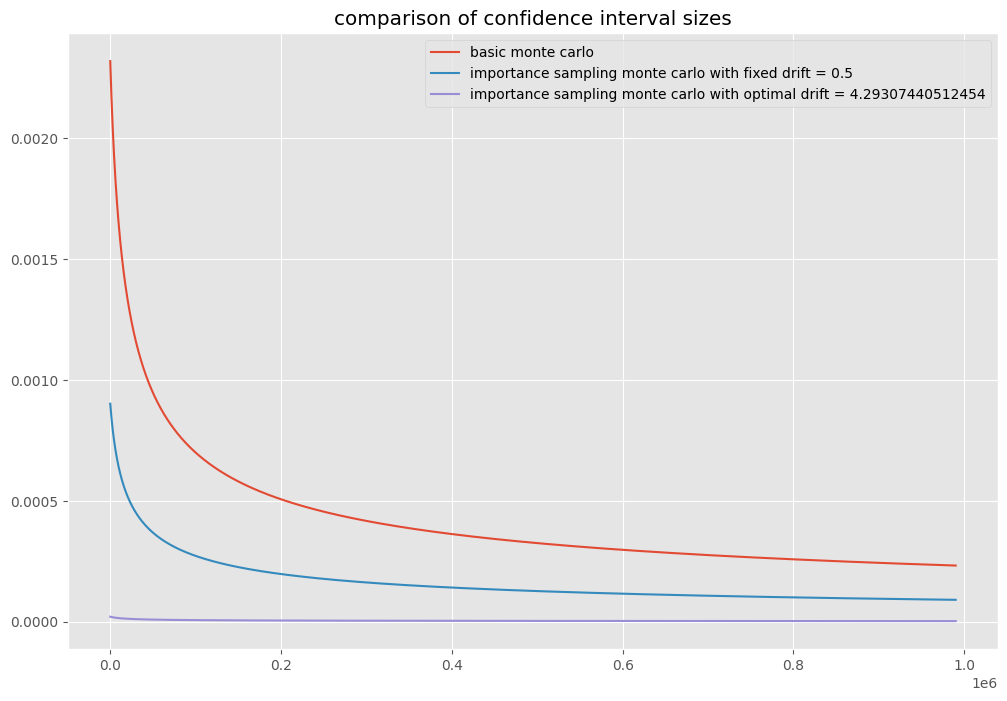

In [13]:
plt.plot(basic_interval_range[int(len(basic_interval_range) * fima.plot_bound):], label = 'basic monte carlo')
plt.plot(is_fixed_interval_range[int(len(is_fixed_interval_range) * fima.plot_bound):], label = 'importance sampling monte carlo with fixed drift = 0.5')
plt.plot(is_opt_interval_range[int(len(is_opt_interval_range) * fima.plot_bound):], label = 'importance sampling monte carlo with optimal drift = ' + str(is_opt_drift))
plt.title('comparison of confidence interval sizes')
plt.legend();